In [23]:
library(nnet)
library(party)
library(randomForest)
library(e1071)
library(caret)
library(dplyr)
library(plotrix)

In [24]:
train_df <- read.csv("../Data/Titanic_train.csv")
train_df <- arrange(train_df,Survived) # Survived 기준으로 정렬, 사망자가 먼저

### Age NA 값 삭제하기

In [25]:
train_df_del <- subset(train_df, Age != 'NA')

### 연령대 4분할 하여 생존/사망 비율 확인하기

In [26]:
summary(train_df_del$Age) # 소수점이 있네?
# 0~20세, 20세~28세, 28세~38세, 38세~80세
train_df_del$AgeGroup <- ifelse(train_df_del$Age <= 20, 'Age1', ifelse(train_df_del$Age <= 28, 'Age2', ifelse(train_df_del$Age<=38, 'Age3', 'Age4')))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   20.12   28.00   29.70   38.00   80.00 

In [27]:
table(train_df_del$AgeGroup)


Age1 Age2 Age3 Age4 
 179  183  175  177 


 0  1 
97 82 


  0   1 
117  66 


 0  1 
99 76 


  0   1 
111  66 

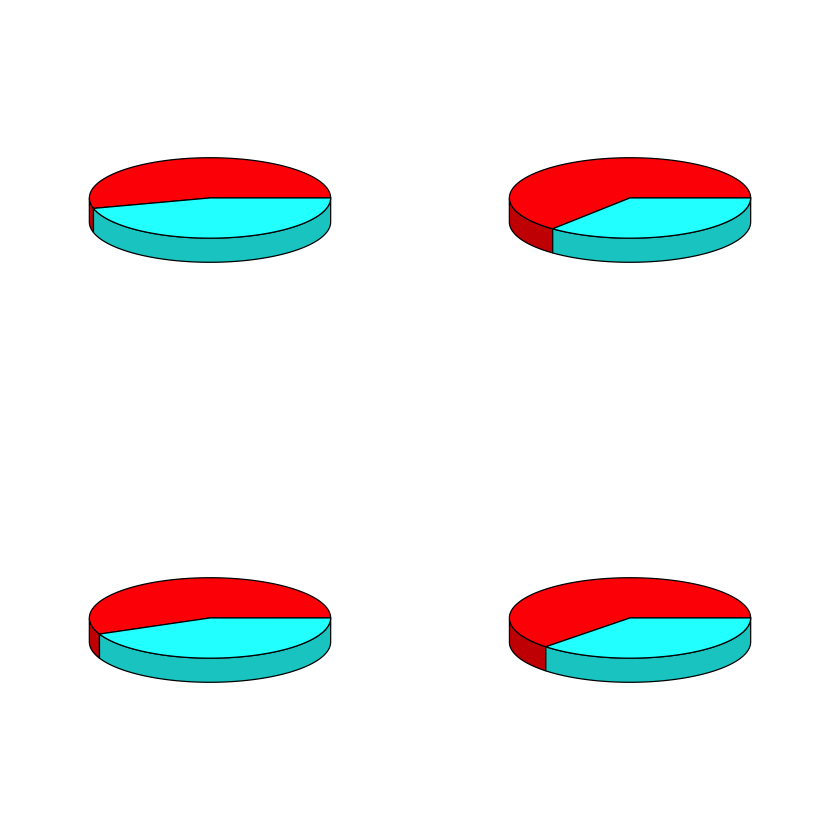

In [28]:
table(train_df_del$Survived[train_df_del$AgeGroup=='Age1'])
table(train_df_del$Survived[train_df_del$AgeGroup=='Age2'])
table(train_df_del$Survived[train_df_del$AgeGroup=='Age3'])
table(train_df_del$Survived[train_df_del$AgeGroup=='Age4'])
par(mfrow=c(2,2))
pie3D(table(train_df_del$Survived[train_df_del$AgeGroup=='Age1']))
pie3D(table(train_df_del$Survived[train_df_del$AgeGroup=='Age2']))
pie3D(table(train_df_del$Survived[train_df_del$AgeGroup=='Age3']))
pie3D(table(train_df_del$Survived[train_df_del$AgeGroup=='Age4']))

> 유의미한 차이점이 없어보임

In [29]:
train_df_del$Embarked <- as.character(train_df_del$Embarked) # 문자로 바꾸지 않으면 숫자들로 인식해서 값을 넣을때 숫자와 문자(S)가 병행된다.
train_df_del$Embarked <- ifelse(train_df_del$Embarked=='', 'S', train_df_del$Embarked)
subset(train_df_del,Embarked=='')

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup


In [30]:
train_df_del$Embarked <- factor(train_df_del$Embarked)

In [31]:
table(train_df_del$Embarked)
str(train_df_del)


  C   Q   S 
130  28 556 

'data.frame':	714 obs. of  13 variables:
 $ PassengerId: int  1 5 7 8 13 14 15 17 19 21 ...
 $ Survived   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pclass     : int  3 3 1 3 3 3 3 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 16 516 625 730 29 841 683 840 274 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 2 2 2 2 2 1 2 1 2 ...
 $ Age        : num  22 35 54 2 20 39 14 2 31 35 ...
 $ SibSp      : int  1 0 0 3 0 1 0 4 1 0 ...
 $ Parch      : int  0 0 0 1 0 5 0 1 0 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 473 86 396 536 334 414 481 302 140 ...
 $ Fare       : num  7.25 8.05 51.86 21.07 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 1 131 1 1 1 1 1 1 1 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 3 3 3 3 3 3 2 3 3 ...
 $ AgeGroup   : chr  "Age2" "Age3" "Age4" "Age1" ...


### Age 2분할 : 어린이(12세 이하), 나머지, 노인(60세 초과)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   20.12   28.00   29.70   38.00   80.00 

   
    Age1 Age2 Age3
  0   29  378   17
  1   40  245    5

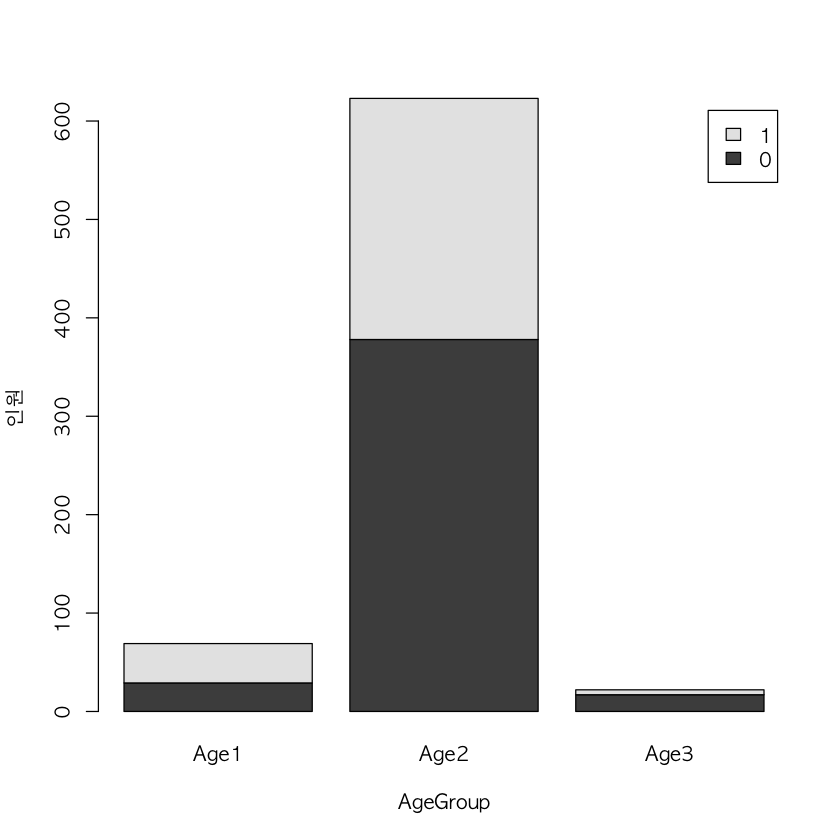

In [32]:
summary(train_df_del$Age) # 소수점이 있네?

train_df_del$AgeGroup <- ifelse(train_df_del$Age <= 12, 'Age1', ifelse(train_df_del$Age <= 60, 'Age2', 'Age3'))

table(train_df_del$Survived,train_df_del$AgeGroup)
options(warn=-1)
par(family="AppleGothic")
barplot(table(train_df_del$Survived,train_df_del$AgeGroup),
  xlab='AgeGroup',
  ylab='인원',
  legend.text=T
)

> 연령대 2분할도 딱히 의미가 없다 : 비율이 비등하다

In [33]:
# Sex 컬럼을 숫자로 전환
train_df_del$SexCode[train_df_del$Sex=='male'] <- 0
train_df_del$SexCode[train_df_del$Sex=='female'] <- 1
head(train_df_del)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,SexCode
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,Age2,0
2,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,Age2,0
4,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,Age2,0
5,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S,Age1,0
6,13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S,Age2,0
7,14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.2750,,S,Age2,0


### One-Hot encoding

In [34]:
# Embarked 3분할
train_df_del$Embarked_C = train_df_del$Embarked=='C'
train_df_del$Embarked_S = train_df_del$Embarked=='S'
train_df_del$Embarked_Q = train_df_del$Embarked=='Q'
head(train_df_del[c('Embarked','Embarked_C','Embarked_S','Embarked_Q')])

,Embarked,Embarked_C,Embarked_S,Embarked_Q
1,S,FALSE,TRUE,FALSE
2,S,FALSE,TRUE,FALSE
4,S,FALSE,TRUE,FALSE
5,S,FALSE,TRUE,FALSE
6,S,FALSE,TRUE,FALSE
7,S,FALSE,TRUE,FALSE


In [35]:
# Age 3분할
train_df_del$Age_1 = train_df_del$AgeGroup=='Age1'
train_df_del$Age_2 = train_df_del$AgeGroup=='Age2'
train_df_del$Age_3 = train_df_del$AgeGroup=='Age3'
head(train_df_del[c('AgeGroup','Age_1','Age_2','Age_3')])

,AgeGroup,Age_1,Age_2,Age_3
1,Age2,FALSE,TRUE,FALSE
2,Age2,FALSE,TRUE,FALSE
4,Age2,FALSE,TRUE,FALSE
5,Age1,TRUE,FALSE,FALSE
6,Age2,FALSE,TRUE,FALSE
7,Age2,FALSE,TRUE,FALSE


### Pclass 2분할 : 1등 객실, 나머지

   
      1   2   3
  0  64  90 270
  1 122  83  85

   
    Pclass1 Pclass2
  0      64     360
  1     122     168

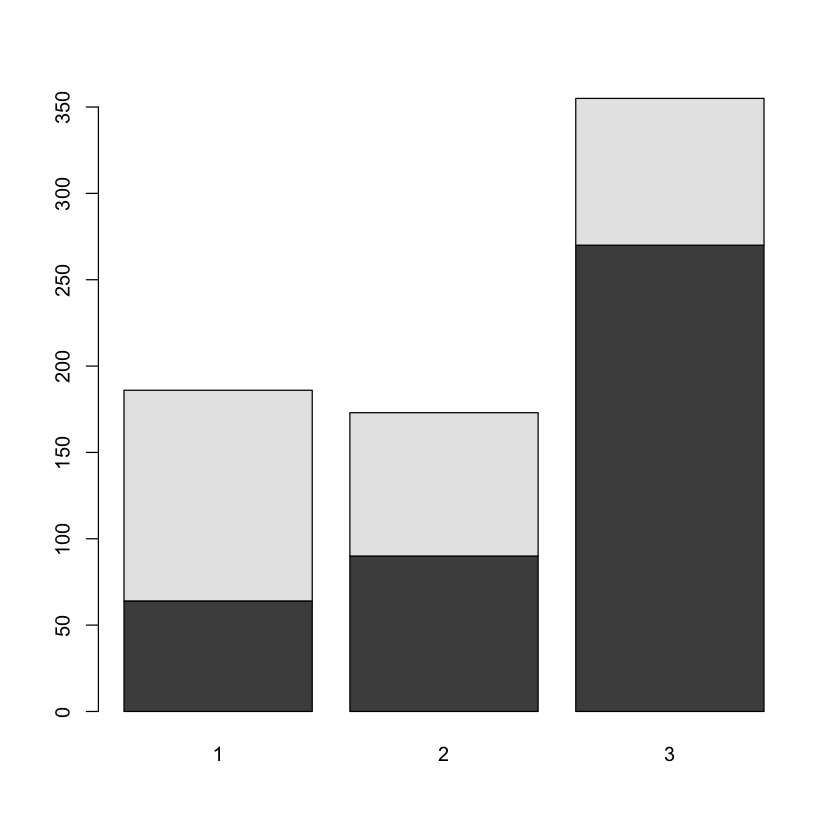

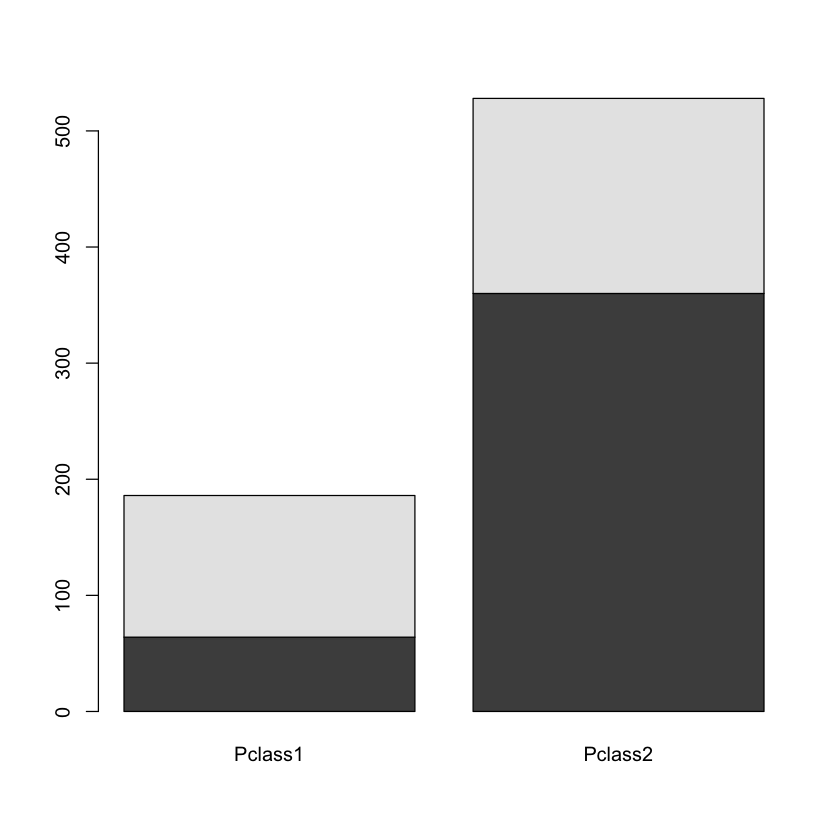

In [36]:
train_df_del$PclassGroup <- ifelse(train_df_del$Pclass <= 1, 'Pclass1', 'Pclass2')
table(train_df_del$Survived,train_df_del$Pclass)
barplot(table(train_df_del$Survived,train_df_del$Pclass))
table(train_df_del$Survived,train_df_del$PclassGroup)
barplot(table(train_df_del$Survived,train_df_del$PclassGroup))

> 등급도 2분할 할 필요가 없다

### Target dataset 만들기

In [37]:
head(train_df_del)
target_col=c('Survived','Pclass','SexCode','Embarked_C',"Embarked_S",'Embarked_Q','Age_1','Age_2','Age_3')
head(train_df_del[,target_col])
train_data <- (train_df_del[,target_col])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,AgeGroup,SexCode,Embarked_C,Embarked_S,Embarked_Q,Age_1,Age_2,Age_3,PclassGroup
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,S,Age2,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,Pclass2
2,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,S,Age2,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,Pclass2
4,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,...,S,Age2,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,Pclass1
5,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,...,S,Age1,0,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,Pclass2
6,13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,...,S,Age2,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,Pclass2
7,14,0,3,"Andersson, Mr. Anders Johan",male,39,1,5,347082,31.2750,...,S,Age2,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,Pclass2


,Survived,Pclass,SexCode,Embarked_C,Embarked_S,Embarked_Q,Age_1,Age_2,Age_3
1,0,3,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE
2,0,3,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE
4,0,1,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE
5,0,3,0,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
6,0,3,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE
7,0,3,0,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE


In [38]:
# Target Column인 Survived를 factor로 만들기
str(train_data)
train_data$Survived <- as.factor(train_data$Survived)
train_data$Survived <- as.factor(train_data$Survived)
str(train_data)
nrow(train_data)

'data.frame':	714 obs. of  9 variables:
 $ Survived  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pclass    : int  3 3 1 3 3 3 3 3 3 2 ...
 $ SexCode   : num  0 0 0 0 0 0 1 0 1 0 ...
 $ Embarked_C: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Embarked_S: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Embarked_Q: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Age_1     : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ Age_2     : logi  TRUE TRUE TRUE FALSE TRUE TRUE ...
 $ Age_3     : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
'data.frame':	714 obs. of  9 variables:
 $ Survived  : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Pclass    : int  3 3 1 3 3 3 3 3 3 2 ...
 $ SexCode   : num  0 0 0 0 0 0 1 0 1 0 ...
 $ Embarked_C: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Embarked_S: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Embarked_Q: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Age_1     : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ Age_2     : logi  TRUE TRUE TRUE FALSE 

[1] 714

In [39]:
# Sampling
set.seed(1234)
samp <- createDataPartition(train_data$Survived, p=0.7, list=F)
# 학습용
data.train.age <- train_data[samp,]
nrow(data.train.age)

# 검증용
data.test.age <- train_data[-samp,]

# 문제 및 정답 만들기
x <- subset(data.test.age, select=-Survived)
y <- data.test.age$Survived

[1] 500

In [40]:
# 학습하기
nnet <- nnet(Survived~.,data=data.train.age, size=2)

# 검증하기
pred.nnet <- predict(nnet, x,type='class')

# 예측율  
mean(pred.nnet == y)
table(pred.nnet,y)

# weights:  21
initial  value 361.864569 
iter  10 value 257.411873
iter  20 value 223.073834
iter  30 value 210.231500
iter  40 value 207.366754
iter  50 value 204.421439
iter  60 value 202.826503
iter  70 value 202.741241
iter  80 value 202.740749
final  value 202.738359 
converged


[1] 0.8271028

         y
pred.nnet   0   1
        0 117  27
        1  10  60

In [41]:
 # 학습하기
  mul <- multinom(Survived~.,data=data.train.age)

  # 검증하기
  pred <- predict(mul, x)

  # 예측율
  mean(pred == y)
  table(pred,y)

# weights:  10 (9 variable)
initial  value 346.573590 
iter  10 value 225.789068
final  value 225.778050 
converged


[1] 0.7803738

    y
pred  0  1
   0 98 18
   1 29 69

In [42]:
# 인공신경망
nnetF <- function(q){
  result = 0
  for(i in 1:q){
    # 학습하기
    nnet <- nnet(Survived~.,data=data.train.age, size=2)

    # 검증하기
    pred <- predict(nnet, x, type='class') # type class로 0과 1 예측하기

    # 예측율  
    mean(pred == y)
    table(pred,y)
    # 예측율  
    result = (result + mean(pred == y))
  }
  return(result/q)
}

# 의사결정나무
ctreeF <- function(q){
  result = 0
  for(i in 1:q){
  # 학습하기
  ctree <- ctree(Survived~.,data=data.train.age)

  # 검증하기
  pred <- predict(ctree, x) # 이하, type class 안해도 0과 1로 예측

  # 예측율
  result <- (result + mean(pred == y))
  }
  return(result/q)
}

# Random Forest
rfF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  rf <- randomForest(Survived~.,data=data.train.age, ntree=100)

  # 검증하기
  pred <- predict(rf, x)

  # 예측율  
  result <- (result + mean(pred == y))
  }
  return(result/q)
}

# SVM
svmF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  svm = svm(Survived~.,data=data.train.age)

  # 검증하기
  pred <- predict(svm, x)

  # 예측율
  result <- (result + mean(pred == y))
  }
  return(result/q)
}

# 다항 로지스틱 회귀분석
mulF <- function(q){  
  result = 0
  for(i in 1:q){
  # 학습하기
  mul <- multinom(Survived~.,data=data.train.age)

  # 검증하기
  pred <- predict(mul, x)

  # 예측율  
  result <- (result + mean(pred == y))
  }
  return(result/q)
}


In [43]:
final <- function(q){
  result <- data.frame(예측력=c(nnetF(q),ctreeF(q),rfF(q),svmF(q),mulF(q)))
  rownames(result) <- c('인공신경망','의사결정나무','RandomForest','SVM','로지스틱회귀분석')
  return(result)
}

In [44]:
final(5)

# weights:  21
initial  value 369.170033 
iter  10 value 227.514632
iter  20 value 225.643887
iter  30 value 225.163337
iter  40 value 219.297808
iter  50 value 211.174993
iter  60 value 206.561246
iter  70 value 205.136765
iter  80 value 205.052025
iter  90 value 203.544694
iter 100 value 203.156089
final  value 203.156089 
stopped after 100 iterations
# weights:  21
initial  value 365.748017 
iter  10 value 231.785476
iter  20 value 210.211917
iter  30 value 204.789354
iter  40 value 204.295798
iter  50 value 204.137730
iter  60 value 203.426311
iter  70 value 202.521289
iter  80 value 202.343961
iter  90 value 202.330757
iter 100 value 202.304519
final  value 202.304519 
stopped after 100 iterations
# weights:  21
initial  value 343.206395 
iter  10 value 235.270459
iter  20 value 223.151668
iter  30 value 217.953036
iter  40 value 212.162525
iter  50 value 209.223080
iter  60 value 208.247538
iter  70 value 208.170550
iter  80 value 207.797906
iter  90 value 207.752416
iter 100 val

,예측력
인공신경망,0.8065421
의사결정나무,0.8037383
RandomForest,0.8392523
SVM,0.7897196
로지스틱회귀분석,0.7803738
